In [ ]:
import sys
import os
from os.path import dirname as dr
from os.path import abspath as ab

sys.path.append(ab(os.getcwd()))
sys.path.append("..")

In [ ]:
import sys
sys.path.append(".")

In [ ]:
sys.path.append(os.getcwd())

In [ ]:
from os.path import dirname as dr
sys.path.append(dr(os.getcwd()))

In [ ]:
dr(ab(os.getcwd()))

In [ ]:
DATA_DIR = '/home/congyu/dataset/ECG/mitbihcsv/'
MITBIH_CLASSES = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F']  # , 'P', '/', 'f', 'u']
AAMI = {
    "N":  ['N', 'L', 'R'],
    "SVEB": ['A', 'a', 'J', 'S', 'e', 'j'],
    "VEB": ['V', 'E'],
    "F": ['F'],
    # "Q": ['P', '/', 'f', 'u'],
}

DS_bank = {
    "normal": {
        "DS1": [101, 106, 108, 109, 112, 114, 115, 116, 118, 119,
                122, 124, 201, 203, 205, 207, 208, 209, 215, 220,
                223, 230],
        "DS2": [100, 103, 105, 111, 113, 117, 121, 123, 200, 202,
                210, 212, 213, 214, 219, 221, 222, 228, 231, 232,
                233, 234]
    },
    "reduced": {
        "DS1": [101, 106, 108, 109, 112, 115, 118, 119, 201, 203,
                205, 207, 208, 209, 215, 220, 223, 230],
        "DS2": [105, 111, 113, 121, 200, 202, 210, 212, 213, 214,
                219, 221, 222, 228, 231, 232, 233, 234]
    }
}


AAMI_CLASSES = sorted(AAMI.keys())

In [ ]:
import os

In [ ]:
def mitbih2aami(label):
    for aami_label, mitbih_label in AAMI.items():
        if label in mitbih_label:
            return aami_label
    return None


In [ ]:
def load_ecg_from_csv(filename):
    """

    :param filename: str
    :return:
    """

    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')

        next(reader)  # skip first line!
        MLII_index = 1
        V1_index = 2

        ptid = os.path.split(filename)[-1][0:3]
        if int(ptid) == 114:
            MLII_index = 2
            V1_index = 1

        MLII = []
        V1 = []
        for row in reader:
            MLII.append((int(row[MLII_index])))
            V1.append((int(row[V1_index])))

    return MLII, V1


In [ ]:
DATA_DIR = '/home/congyu/dataset/ECG/mitbihcsv/'

In [ ]:
def parse_data_dir(data_dir, record_ids):
    """
    return one is a list of ".csv" file, one is a list of ".txt" file
    under the data_dir, whose name has ids in ds

    :param data_dir:
    :param record_ids: List[int]
    :return: Tuple(List[str]), two list,
       one is a list of ".csv" file, one is a list of ".txt" file
    """
    # Read files: signal (.csv )  annotations (.txt)
    fRecords = list()
    fAnnotations = list()

    lst = os.listdir(data_dir)
    lst.sort()
    for filename in lst:
        if filename.endswith(".csv"):
            if int(filename[0:3]) in record_ids:
                fRecords.append(filename)
        elif filename.endswith(".txt"):
            if int(filename[0:3]) in record_ids:
                fAnnotations.append(filename)

    return fRecords, fAnnotations


In [ ]:
DS1 = [101, 106, 108, 109, 112, 115, 118, 119, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]

In [ ]:
fRecords, fAnnotations = parse_data_dir(DATA_DIR, DS1)

In [ ]:
filename = os.path.join(DATA_DIR, fRecords[0])

In [ ]:
import csv

In [ ]:
mlii, v1 = load_ecg_from_csv(filename)

In [ ]:
def load_ann_from_txt(filename):
    """

    :param filename: str
    :return:
    """

    with open(filename, "r") as f:
        next(f)  # skip first line!
        annotations = []
        for line in f:
            annotations.append(line)
    return annotations

In [ ]:
filename = os.path.join(DATA_DIR, fAnnotations[0])
annotations = load_ann_from_txt(filename)

In [ ]:
def parse_annotations(annotations, MLII, ws=(90, 90), size_rr_max=20):
    """

    :param annotations:
    :param MLII:
    :param ws:
    :param size_rr_max:
    :return:
        beat_indices, List[Tuple], Tuple is (beat_start_index, r_peak_index, beat_end_index).
        labels, List[str], str is the lable of the beat.
    """

    beat_indices = []
    labels = []
    r_peaks_original = []
    is_r_valid = []

    for a in annotations:
        _, r_pos, beat_label = a.split()[:3]

        r_pos = int(r_pos)
        r_peaks_original.append(r_pos)

        beat_index, label = parse_beats(r_pos, beat_label, MLII, ws, size_rr_max)
        if label:
            labels.append(label)
            beat_indices.append(beat_index)
            is_r_valid.append(1)
        else:
            is_r_valid.append(0)

    return beat_indices, labels, r_peaks_original, is_r_valid

In [ ]:
def parse_beats(r_pos, beat_type, MLII, ws, size_RR_max=20):
    """

    :param r_pos: int, r-peak index
    :param beat_type: str, mitbih label.
    :param MLII: List[float], ECG in lead MLII
    :param ws: Tuple[int], (winL, winR), window size
    :param size_RR_max: int, related to sample rate
    :return: Tuple, str, str is AAMI label.
    """

    winL, winR = ws
    beatL = None
    beatR = None
    class_AAMI = None

    r_pos = relocate_r_peak(r_pos, MLII, size_RR_max)

    if winL < r_pos < (len(MLII) - winR) and beat_type in MITBIH_CLASSES:
        beatL = r_pos - winL
        beatR = r_pos + winR
        class_AAMI = mitbih2aami(beat_type)

    return (beatL, r_pos, beatR), class_AAMI


In [ ]:
def relocate_r_peak(r_pos, ref_signal, rr_max):
    """

    :param r_pos: int, r_peak index
    :param ref_signal: List[float], reference signal
    :param rr_max: int,
    :return:
    """

    # relocate r_peak by searching maximum in ref_signal
    # r_pos between [size_RR_max, len(MLII) - size_RR_max]
    if rr_max < r_pos < len(ref_signal) - rr_max:
        index, value = max(enumerate(ref_signal[r_pos - rr_max: r_pos + rr_max]), key=operator.itemgetter(1))
        return (r_pos - rr_max) + index
    return r_pos

In [ ]:
import operator

In [ ]:
beat_indices, labels, _, _ = parse_annotations(annotations, mlii)

In [ ]:
import sys 

In [ ]:
from load_MITBIH import load_signal

In [ ]:
my_db = load_signals(DS1, (90, 90), False)

In [ ]:
from mit_db import mit_db, RR_intervals

In [ ]:
DS1 = [101, 106, 108, 109, 112, 115, 118, 119, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]

In [ ]:
RR = [RR_intervals() for i in range(len(DS1))]

In [ ]:
for p in range(len(my_db.beat)):
    if maxRR:
        RR[p] = compute_RR_intervals(my_db.R_pos[p])
    else:
        RR[p] = compute_RR_intervals(my_db.orig_R_pos[p])

    RR[p].pre_R = RR[p].pre_R[(my_db.valid_R[p] == 1)]
    RR[p].post_R = RR[p].post_R[(my_db.valid_R[p] == 1)]
    RR[p].local_R = RR[p].local_R[(my_db.valid_R[p] == 1)]
    RR[p].global_R = RR[p].global_R[(my_db.valid_R[p] == 1)]


In [ ]:
import numpy as np

In [ ]:
f_RR = np.empty((0, 4))
for p in range(10):
    row = np.column_stack(([1, 2],[11, 22],[111,222],[1111,2222]))
    f_RR = np.vstack((f_RR, row))

In [ ]:
f_RR

In [1]:
from load_MITBIH import *
from constant import *

In [2]:
my_db = load_signals(record_ids=DS_bank["reduced"]["DS1"][:1], ws=(90, 90), do_preprocess=True)

100%|██████████| 1/1 [00:10<00:00, 10.97s/it]


In [3]:
import matplotlib.pyplot as plt

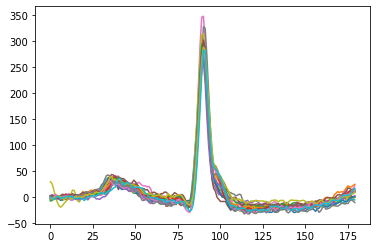

In [6]:
for i in range(20):
    plt.plot(my_db.beat[0][i][0])